# Climate Analysis

In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
print(Base)
# reflect the tables
Base.prepare(engine, reflect=True)

<class 'sqlalchemy.ext.automap.Base'>


In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [16]:
# Get the first row of data in the table to know the exact name of the columns
precip = session.query(Measurement).first()
precip.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1172af400>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [17]:
# Print the last date of the table - 2017-08-23
rows = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for row in rows:
    print(row)

2017-08-23


# Exploratory Climate Analysis

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database (calculated based on the last date)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date) #2016-08-23

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= '2016-08-23').\
        order_by(Measurement.date.desc()).all()

precip

2016-08-23


[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.5),
 ('2017-08-21', 0.0),
 ('2017-08-21', 0.02),
 ('2017-08-21', None),
 ('2017-08-21', 0.56),
 ('2017-08-20', 0.0),
 ('2017-08-20', 0.01),
 ('2017-08-20', None),
 ('2017-08-19', 0.0),
 ('2017-08-19', 0.0),
 ('2017-08-19', None),
 ('2017-08-19', 0.09),
 ('2017-08-18', 0.0),
 ('2017-08-18', 0.0),
 ('2017-08-18', 0.06),
 ('2017-08-18', None),
 ('2017-08-17', 0.0),
 ('2017-08-17', 0.05),
 ('2017-08-17', 0.01),
 ('2017-08-17', 0.13),
 ('2017-08-16', 0.0),
 ('2017-08-16', 0.07),
 ('2017-08-16', 0.12),
 ('2017-08-16', 0.42),
 ('2017-08-15', 0.02),
 ('2017-08-15', 0.0),
 ('2017-08-15', 0.06),
 ('2017-08-15', 0.32),
 ('2017-08-15', 0.42),
 ('2017-08-14', 0.0),
 ('2017-08-14', 0.01),
 ('2017-08-14', 0.08),
 ('2017-08-14', 0.0),
 ('2017-08-14', 0.22),
 ('2017-08-13', 0.0),
 ('2017-08-13', None),
 ('2017-08-13', 0.0),
 ('2017-08-13', 0.0),
 ('2017

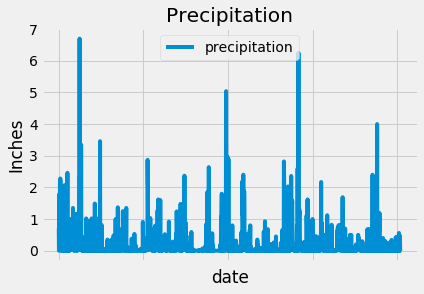

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column

# Save data in a list first
date = [(p[0]) for p in precip]
precipitation = [(p[1]) for p in precip]

# Create a DataFrame
#dict = {'date': date, 'precipitation': precipitation}
#df = pd.DataFrame(dict)
#df.set_index('date', inplace=True)
#df

# Same code as above just written differently
df = pd.DataFrame(precip[:], columns=['date', 'precipitation'])

#set date to index
df.set_index('date', inplace=True)

# Drop rows with Nan
df = df.dropna()

# Sort the dataframe by date
df = df.sort_values(by=['date'])#, ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation")
plt.legend(loc='upper center')
plt.ylabel("Inches")
# Save chart
plt.savefig("Images/precipitation.png")
#Plot chart
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?

#look up the stations
station = session.query(Measurement.station).all()
stations = len(set(station))
stations

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order
session.query(Measurement.id, Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[(12188, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2725, 'USC00513117', 2709),
 (9519, 'USC00519523', 2669),
 (16939, 'USC00516128', 2612),
 (5434, 'USC00514830', 2202),
 (14960, 'USC00511918', 1979),
 (7636, 'USC00517948', 1372),
 (9008, 'USC00518838', 511)]

In [23]:
# Creating query to pull the min, max, avg for all grouped stations
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
            func.avg(Measurement.tobs),\
            func.count(Measurement.tobs)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).all()

[(54.0, 85.0, 71.66378066378067, 2772),
 (56.0, 87.0, 74.55323054331865, 2724),
 (59.0, 85.0, 72.68918420081211, 2709),
 (56.0, 85.0, 74.5436493068565, 2669),
 (58.0, 84.0, 70.91500765696784, 2612),
 (58.0, 85.0, 74.8732970027248, 2202),
 (53.0, 87.0, 71.61596766043456, 1979),
 (58.0, 87.0, 74.68440233236151, 1372),
 (58.0, 83.0, 72.72407045009784, 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
              func.avg(Measurement.tobs)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.tobs).desc()).first()

(54.0, 85.0, 71.66378066378067)

In [25]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

('USC00519281', 2772)

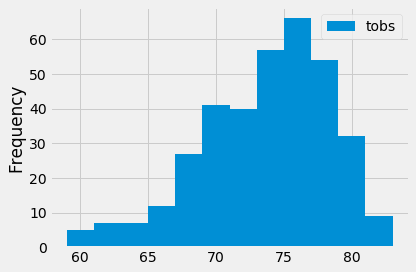

In [26]:
# Find the most recent date - 2017-08-18
session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).all()

# Find the date 12 months ago
query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
query_date #2016-08-28

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date <= '2017-08-18').\
        filter(Measurement.date >= '2016-08-18').\
        order_by(Measurement.date.desc()).all()

# Add the temperatures to list
temp = [tob[1] for tob in tobs]
df = pd.DataFrame(temp, columns=['tobs'])

# Create the histogram
df.plot.hist(bins=12)
plt.tight_layout()
# Save chart
plt.savefig("Images/station-histogram.png")
# Plot chart
plt.show()

# Temperature Analysis (Optional)

In [63]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [102]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation = calc_temps('2016-07-16', '2016-07-30')
vacation = pd.DataFrame(vacation, columns=['tmin', 'tavg', 'tmax'])
vacation

,tmin,tavg,tmax
0,72.0,77.943182,83.0


In [101]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
